# Phase 2: ROI Prediction Engine (Machine Learning)
**Goal:** Build a Linear Regression model to predict Campaign ROI based on Channel, Spend, and Target Audience.

**Strategy Connection:** This allows us to simulate "What-If" scenarios for budget allocation.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Load the clean data from Phase 1
# We expect this file to exist now!
df = pd.read_csv('../data/processed/cleaned_ads_data.csv')

print(f"✅ Loaded Data. Shape: {df.shape}")
df.head(3)

✅ Loaded Data. Shape: (300000, 17)


,Campaign_ID,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Company,Target_Gender,Target_Age_Group
0,529013,Product Launch,15,Instagram,0.15,500.0,5.79,Las Vegas,Spanish,500,3000,7,Health,2022-02-25,Aura Align,Men,35-44
1,275352,Market Expansion,15,Facebook,0.01,500.0,7.21,Los Angeles,French,500,3000,5,Home,2022-05-12,Hearth Harmony,Women,45-60
2,692322,Product Launch,15,Instagram,0.08,500.0,0.43,Austin,Spanish,500,3000,9,Technology,2022-06-19,Cyber Circuit,Men,45-60


### 1. Feature Engineering & Preprocessing
Machine Learning models require numerical input. We need to:
1.  **Select Features:** Choose which columns likely influence ROI.
2.  **One-Hot Encode:** Convert categorical variables (like 'Channel_Used') into binary columns (0s and 1s).

In [3]:
# 1. Select the features for the model
# We exclude 'Campaign_ID' (useless) and 'Date' (too granular for this model)
features = ['Channel_Used', 'Campaign_Goal', 'Acquisition_Cost', 'Duration', 'Target_Gender', 'Target_Age_Group']
target = 'ROI'

X = df[features]
y = df[target]

# 2. One-Hot Encoding
# drop_first=True avoids multicollinearity (e.g., if it's not Male, it must be Female)
X_encoded = pd.get_dummies(X, drop_first=True)

print("Features ready for modeling:")
print(X_encoded.columns.tolist())

Features ready for modeling:
['Acquisition_Cost', 'Duration', 'Channel_Used_Instagram', 'Channel_Used_Pinterest', 'Channel_Used_Twitter', 'Campaign_Goal_Increase Sales', 'Campaign_Goal_Market Expansion', 'Campaign_Goal_Product Launch', 'Target_Gender_Men', 'Target_Gender_Women', 'Target_Age_Group_25-34', 'Target_Age_Group_35-44', 'Target_Age_Group_45-60', 'Target_Age_Group_Ages']


### 2. Train/Test Split
We split the data into **Training (80%)** and **Testing (20%)** sets.
* **Train:** The model learns the patterns here.
* **Test:** We grade the model on this unseen data to ensure it isn't "cheating" (overfitting).

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape[0]} rows")
print(f"Testing Set:  {X_test.shape[0]} rows")

Training Set: 240000 rows
Testing Set:  60000 rows


### 3. Model Training (Linear Regression)
We use Linear Regression because it is **highly interpretable**. In a business context, explaining *why* a prediction was made (via coefficients) is often more important than a slightly higher accuracy from a "Black Box" model.

In [5]:
# Initialize and Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the Test Set
predictions = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("--- Model Performance ---")
print(f"R² Score: {r2:.3f} (Explains {r2*100:.1f}% of the variance in ROI)")
print(f"Mean Absolute Error: {mae:.2f} (On average, our prediction is off by {mae:.2f} ROI points)")

--- Model Performance ---
R² Score: 0.332 (Explains 33.2% of the variance in ROI)
Mean Absolute Error: 1.59 (On average, our prediction is off by 1.59 ROI points)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


### 4. Strategic Insight: Feature Importance
This is the most critical step for the Portfolio. We extract the **Coefficients** to see which factors drive ROI up or down.

* **Positive Coefficient:** This feature **increases** ROI.
* **Negative Coefficient:** This feature **decreases** ROI.

/var/folders/80/vx7bsx9917v8fw_1j_dc367h0000gn/T/ipykernel_41632/2129199270.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeffs, y='Feature', x='Impact_on_ROI', palette='coolwarm')


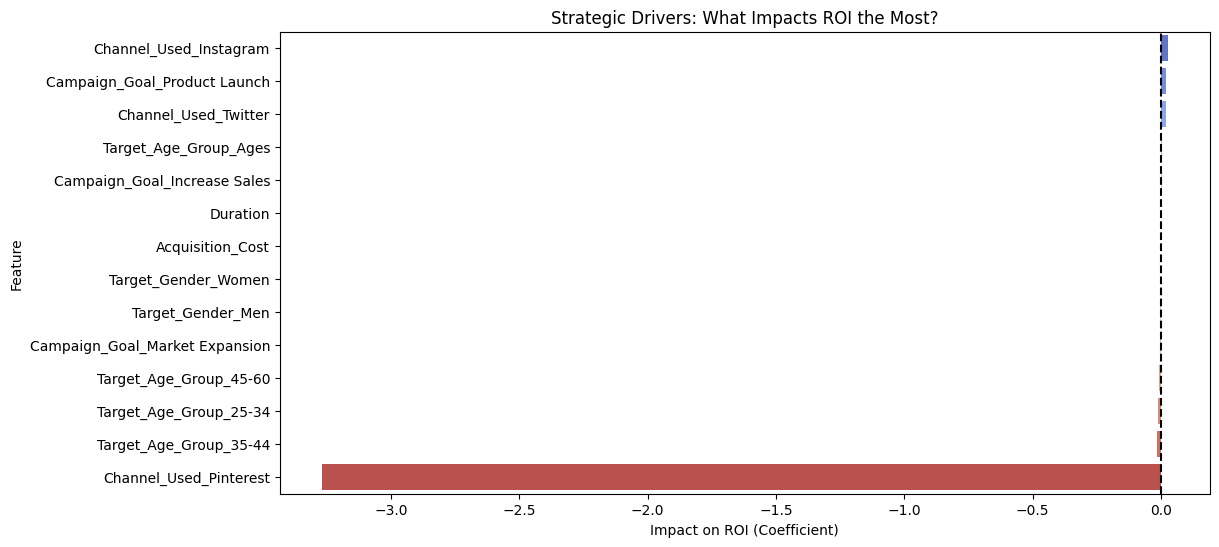

Top 3 ROI Drivers:
                        Feature  Impact_on_ROI
2        Channel_Used_Instagram       0.025117
7  Campaign_Goal_Product Launch       0.020198
4          Channel_Used_Twitter       0.020163

Top 3 ROI Killers:
                   Feature  Impact_on_ROI
10  Target_Age_Group_25-34      -0.011896
11  Target_Age_Group_35-44      -0.016129
3   Channel_Used_Pinterest      -3.268728


In [6]:
# Extract coefficients
coeffs = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Impact_on_ROI': model.coef_
}).sort_values(by='Impact_on_ROI', ascending=False)

# Visualizing the Top Drivers
plt.figure(figsize=(12, 6))
sns.barplot(data=coeffs, y='Feature', x='Impact_on_ROI', palette='coolwarm')
plt.title("Strategic Drivers: What Impacts ROI the Most?")
plt.xlabel("Impact on ROI (Coefficient)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

# Display the exact numbers for the top 3 and bottom 3
print("Top 3 ROI Drivers:")
print(coeffs.head(3))
print("\nTop 3 ROI Killers:")
print(coeffs.tail(3))